In [20]:
!pip install xgboost

In [21]:
from google.colab import files

uploaded = files.upload()

import pandas as pd

# Read the Excel file
df = pd.read_excel("realestatedata.xlsx")
df.head()

Saving realestatedata.xlsx to realestatedata (5).xlsx


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN


Columns: ['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street', 'city', 'state', 'zip_code', 'house_size']
R² Score: 0.8416840633922376
Predicted Price: $282,961.88


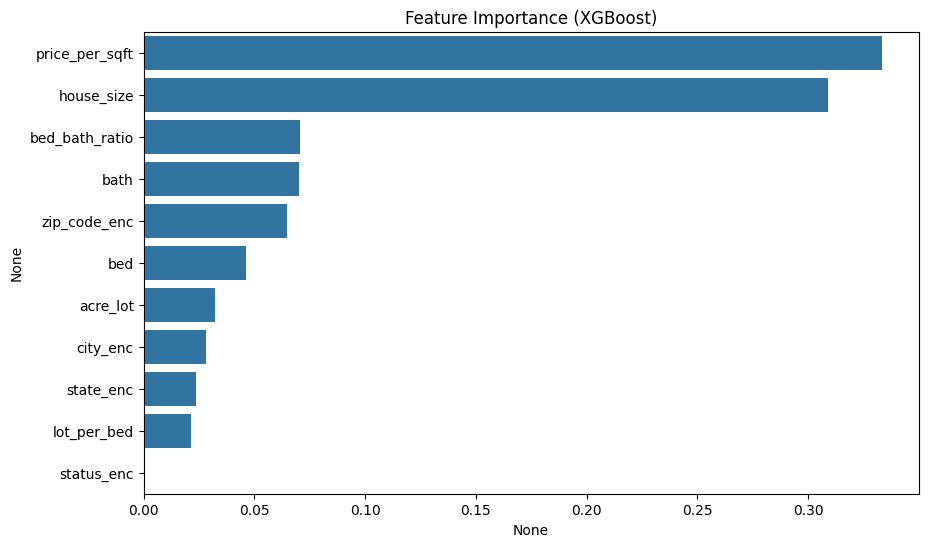

In [22]:
# =============================
# 1. Import Libraries
# =============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# 2. Load Dataset
# =============================
# Example: df = pd.read_csv("realtor-data.csv")
# If already loaded, just clean column names

df.columns = df.columns.str.strip().str.lower()   # standardize column names
print("Columns:", df.columns.tolist())

# =============================
# 3. Handle Missing Values
# =============================
df = df.dropna(subset=['price'])       # must have target
df = df.fillna(0)                      # replace other NaNs with 0

# =============================
# 4. Drop Irrelevant Columns
# =============================
for col in ['street', 'brokered_by']:
    if col in df.columns:
        df = df.drop(columns=[col])

# =============================
# 5. Target Encoding for Categorical Features
# =============================
for col in ['city', 'state', 'zip_code', 'status']:
    mean_price = df.groupby(col)['price'].transform('mean')
    df[col + "_enc"] = mean_price
    df = df.drop(columns=[col])

# =============================
# 6. Feature Engineering
# =============================
df['price_per_sqft'] = df['price'] / (df['house_size'] + 1)
df['bed_bath_ratio'] = df['bed'] / (df['bath'] + 1)
df['lot_per_bed'] = df['acre_lot'] / (df['bed'] + 1)

# =============================
# 7. Define Features & Target
# =============================
X = df.drop('price', axis=1)
y = df['price']

# log-transform target (to reduce skew from high prices)
y = np.log1p(y)

# =============================
# 8. Train-Test Split
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============================
# 9. Train Model (XGBoost)
# =============================
model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# =============================
# 10. Predictions & Evaluation
# =============================
y_pred = model.predict(X_test)

# inverse log-transform
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

# R² Score
print("R² Score:", r2_score(y_test_exp, y_pred_exp))

# =============================
# 11. Predict on a Sample House
# =============================
sample = X_test.iloc[0].to_frame().T
predicted_price = np.expm1(model.predict(sample))[0]
print(f"Predicted Price: ${predicted_price:,.2f}")

# =============================
# 12. Feature Importance Plot
# =============================
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.sort_values(ascending=False),
            y=feat_imp.sort_values(ascending=False).index)
plt.title("Feature Importance (XGBoost)")
plt.show()
